# The CNN With Residual Blocks Model 

CHEST X-RAY IMAGES CLASSIFICATION WITH CNN

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

import os, shutil, pathlib


print("tensorflow version:", tf.__version__)
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)

tensorflow version: 2.10.0
numpy version: 1.23.4
pandas version: 1.5.1


## Paths of Data

In [2]:
DATA_PATH = "../data"
RAW_DATASET_NAME = "20210708_görüntüler"   # raw dataset folder name
SUB_FOLDERS_PATH = f"{DATA_PATH}/{RAW_DATASET_NAME}"  # sub class folders

SUB_FOLDERS_PATH

'../data/20210708_görüntüler'

In [3]:
os.listdir(DATA_PATH)

['20210708_görüntüler', 'images_1', 'manuel_differet_person']

In [4]:
labels = {"covid+ ac grafileri" : "covid",
         "infiltratif akciğer hastası grafileri" : "infiltiratif",
         "normal akciğer grafileri": "normal"}

labels

{'covid+ ac grafileri': 'covid',
 'infiltratif akciğer hastası grafileri': 'infiltiratif',
 'normal akciğer grafileri': 'normal'}

In [5]:
labels.values()

dict_values(['covid', 'infiltiratif', 'normal'])

# Prepare Data

In [6]:
def dataframe_for_folders(DATA_PATH, DATASET_NAME, labels):
    """create dataframe from data folders that every folder has one class data
    
    It prepares dataframe to put in  TF flow_from_dataframe function
    
    Args:
        DATA_PATH : parent folder relative path of DATASET_NAME. It contains all of data files.
        DATASET_NAME : dataset name which wanted to use - path from DATA_PATH to classes folders
        labels: a dict that contains folder names according to classes
        
    Returns:
        A pandas dataframe that has relative path to the dataset_name of data and labels
    """
    CLASS_FOLDERS_PATHS = os.listdir(f"{DATA_PATH}/{DATASET_NAME}")
    
    df = pd.DataFrame(columns=["path", "label"])  # empty dataframe
    
    for i in CLASS_FOLDERS_PATHS:
        # list files - images
        list_of_files = os.listdir(f"{DATASET_NAME}/{i}")
        
        for k, name in enumerate(list_of_files):
            list_of_files[k] = f"{i}/"+name       # add parent folder

        df = pd.concat([df, pd.DataFrame(list_of_files, columns=["path"])], ignore_index=True)
        df.fillna(labels[i], inplace=True)  # label column is NaN, so we put labels every iteration. because every folder has one class        
    
#     df.reset_index(inplace = True)  
    
    return df

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    336 non-null    object
 1   label   336 non-null    object
dtypes: object(2)
memory usage: 5.4+ KB


## Split Train and Test Data

In [10]:
from sklearn.model_selection import train_test_split

random_state=41
test_size = 0.2
df_train, df_test = train_test_split(df , test_size = test_size, random_state=random_state)

In [12]:
type(df.label.value_counts())

pandas.core.series.Series

In [13]:
df.label.value_counts().index

Index(['covid', 'normal', 'infiltiratif'], dtype='object')

covid           128
normal          107
infiltiratif    101
Name: label, dtype: int64


Text(0.5, 1.0, 'Rates of Classes on All of Data')

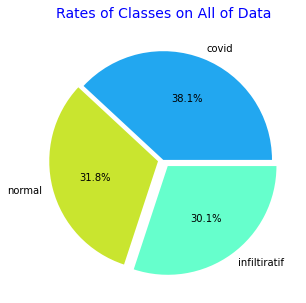

In [14]:
# Rates of Classes on All of Data
print(df.label.value_counts())

colors = ["#22a7f0","#c9e52f", "#66ffcc"]
# classes = ['covid', 'normal', "infiltiratif"]
classes = df.label.value_counts().index
explode = [0, 0.05, 0.07]

plt.figure(figsize = (5,5))
plt.pie(df.label.value_counts(), explode=explode, labels=classes, colors=colors, autopct='%1.1f%%')
plt.title("Rates of Classes on All of Data", color = 'blue',fontsize = 14)

covid           103
normal           86
infiltiratif     79
Name: label, dtype: int64


Text(0.5, 1.0, 'Rates of Classes on Train Data')

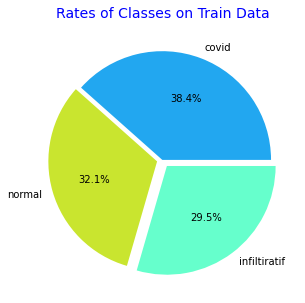

In [15]:
# Rates of Classes on Train Data
print(df_train.label.value_counts())

colors = ["#22a7f0","#c9e52f", "#66ffcc"]
# classes = ['covid', 'normal', "infiltiratif"]
classes = df_train.label.value_counts().index
explode = [0, 0.05, 0.07]

plt.figure(figsize = (5,5))
plt.pie(df_train.label.value_counts(), explode=explode, labels=classes, colors=colors, autopct='%1.1f%%')
plt.title("Rates of Classes on Train Data", color = 'blue',fontsize = 14)

covid           25
infiltiratif    22
normal          21
Name: label, dtype: int64


Text(0.5, 1.0, 'Rates of Classes on Test Data')

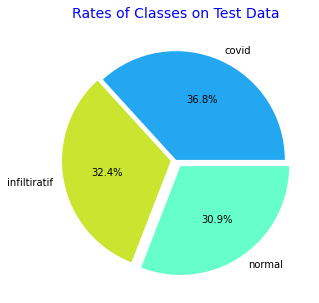

In [16]:
# Rates of Classes on Test Data
print(df_test.label.value_counts())

colors = ["#22a7f0","#c9e52f", "#66ffcc"]
# classes = ['covid', 'normal', "infiltiratif"]
classes = df_test.label.value_counts().index
explode = [0, 0.05, 0.07]

plt.figure(figsize = (5,5))
plt.pie(df_test.label.value_counts(), explode=explode, labels=classes, colors=colors, autopct='%1.1f%%')
plt.title("Rates of Classes on Test Data", color = 'blue',fontsize = 14)

# Preprocessing - Load Data

In [17]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
SUB_FOLDERS_PATH

'../data/20210708_görüntüler'

In [19]:
width = 480
height = 480

input_size = (width, height)
input_shape = (width, height, 3)

batch_size = 4
val_batch_size = 4
test_batch_size = 4

epochs = 200


train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                            directory=SUB_FOLDERS_PATH,
                                            x_col="path",
                                            y_col="label",
                                            subset="training",
                                            batch_size=batch_size,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=input_size)

validation_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                            directory=SUB_FOLDERS_PATH,
                                            x_col="path",
                                            y_col="label",
                                            subset="validation",
                                            batch_size=val_batch_size,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=input_size)

test_generator = test_datagen.flow_from_dataframe(dataframe=df_test,
                                            directory=SUB_FOLDERS_PATH,
                                            x_col="path",
                                            y_col="label",
                                            batch_size=test_batch_size,
                                            seed=42,
                                            shuffle=False,
                                            class_mode="categorical",
                                            target_size=input_size)


Found 201 validated image filenames belonging to 3 classes.
Found 67 validated image filenames belonging to 3 classes.
Found 68 validated image filenames belonging to 3 classes.


# New CNN with Residual Blocks

In [21]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity

## Identity Block
`The identity block is a slightly different and more powerful version of the standard block used in ResNets, and corresponds to the case where the input activation (say 𝑎[𝑙]) has the same dimension as the output activation (say 𝑎[𝑙+2]).`

[Source: Convolutional Neural Networks on Coursera by Andrew NG](https://www.coursera.org/learn/convolutional-neural-networks)

<img src="images/idblock3_kiank.png" style="width:650px;height:150px;">
    <caption><center> <u> <font color='purple'> <b>Figure 1</b> </u><font color='purple'>  : <b>Identity block.</b> Skip connection "skips over" 3 layers.</center></caption>

In [22]:

def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 1
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    ### START CODE HERE
    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed = 0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) 
    
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    ### END CODE HERE

    return X


## The Convolutional Block 
`The ResNet "convolutional block" is the second block type. You can use this type of block when the input and output dimensions don't match up.`

[Source: Convolutional Neural Networks on Coursera by Andrew NG](https://www.coursera.org/learn/convolutional-neural-networks)

<img src="images/convblock_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> <b>Figure 2</b> </u><font color='purple'>  : <b>Convolutional block</b> </center></caption>

In [23]:

def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    
    ## Second component of main path
    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed = 0))(X)
    X = BatchNormalization(axis = 3)(X, training=training) 
    X = Activation('relu')(X)

    ## Third component of main path
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed = 0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    
    ##### SHORTCUT PATH #####
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s,s), padding = 'valid', kernel_initializer = initializer(seed = 0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

# The New Model

In [24]:

def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = layers.Conv2D(64, 3, strides=2, padding="same", use_bias=False)(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 128], s = 1)
    X = identity_block(X, 3, [64, 64, 128])
    X = identity_block(X, 3, [64, 64, 128])
    
    
    #### NEW Layers
    for size in [32, 64, 128]:
        
        X = layers.BatchNormalization()(X)
        X = layers.Activation("relu")(X)

        X = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(X)
        X = layers.BatchNormalization()(X)
        X = layers.Activation("relu")(X)

        X = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(X)
        X = layers.MaxPooling2D(3, strides=2, padding="same")(X)
        
        X = layers.Conv2D(size, 3, strides=2, padding="same", use_bias=False)(X)
        X = layers.BatchNormalization()(X)
    
    ## AVGPOOL
    X = AveragePooling2D(pool_size = (2, 2))(X)

    # output layer
    X = Flatten()(X)
    
    X = layers.Dropout(0.5)(X)
    X = layers.Dense(64, activation="relu")(X)
    X = layers.Dropout(0.5)(X)
    
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model


In [26]:
model = ResNet50(input_shape = input_shape, classes = 3)  # covid19 - infiltratrif - normal
print(input_shape)
print(model.summary())

(480, 480, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 486, 486, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 240, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                

 add_1 (Add)                    (None, 120, 120, 12  0           ['activation_3[0][0]',           
                                8)                                'batch_normalization_8[0][0]']  
                                                                                                  
 activation_6 (Activation)      (None, 120, 120, 12  0           ['add_1[0][0]']                  
                                8)                                                                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 120, 120, 64  8256        ['activation_6[0][0]']           
                                )                                                                 
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 120, 120, 64  256        ['conv2d_9[0][0]']               
 rmalizati

                                                                                                  
 batch_normalization_18 (BatchN  (None, 8, 8, 64)    256         ['batch_normalization_17[0][0]'] 
 ormalization)                                                                                    
                                                                                                  
 activation_14 (Activation)     (None, 8, 8, 64)     0           ['batch_normalization_18[0][0]'] 
                                                                                                  
 separable_conv2d_4 (SeparableC  (None, 8, 8, 128)   8768        ['activation_14[0][0]']          
 onv2D)                                                                                           
                                                                                                  
 batch_normalization_19 (BatchN  (None, 8, 8, 128)   512         ['separable_conv2d_4[0][0]']     
 ormalizat

In [27]:
# assert False

# The Model

In [29]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                patience=30,),
                  keras.callbacks.ModelCheckpoint(filepath="checkpoint_path.keras",
                                                  monitor="val_loss",
                                                  save_best_only=True,),
                 keras.callbacks.TensorBoard(log_dir="./tensorboard")]

In [30]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
train_generator.reset()
validation_generator.reset()
history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs, callbacks=callbacks_list, batch_size=batch_size)

Epoch 1/200
51/51 [==============================] - 15s 178ms/step - loss: 0.7911 - accuracy: 0.6219 - val_loss: 1.2222 - val_accuracy: 0.3582
Epoch 2/200
51/51 [==============================] - 6s 111ms/step - loss: 0.6762 - accuracy: 0.6915 - val_loss: 1.6555 - val_accuracy: 0.3582
Epoch 3/200
51/51 [==============================] - 6s 112ms/step - loss: 0.6123 - accuracy: 0.7413 - val_loss: 2.6511 - val_accuracy: 0.3582
Epoch 4/200
51/51 [==============================] - 6s 114ms/step - loss: 0.5384 - accuracy: 0.7662 - val_loss: 3.7662 - val_accuracy: 0.3582
Epoch 5/200
51/51 [==============================] - 6s 111ms/step - loss: 0.4655 - accuracy: 0.8159 - val_loss: 4.0418 - val_accuracy: 0.3582
Epoch 6/200
51/51 [==============================] - 6s 110ms/step - loss: 0.4860 - accuracy: 0.8060 - val_loss: 4.5615 - val_accuracy: 0.3582
Epoch 7/200
51/51 [==============================] - 6s 110ms/step - loss: 0.4662 - accuracy: 0.7910 - val_loss: 3.1669 - val_accuracy: 0.358

# Training Graphs

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

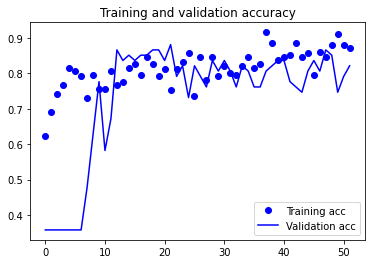

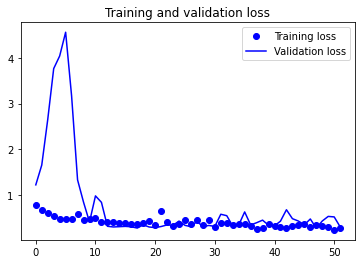

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Reload the best model from Saved on Keras File
"We’ll reload the model from its saved file to evaluate it as it was before it started overfitting."

In [35]:
model = keras.models.load_model("checkpoint_path.keras")

In [36]:
train_generator.reset()
train_loss, train_accuracy = model.evaluate(train_generator)
print("train_loss: ", train_loss)
print("train_accuracy", train_accuracy)

51/51 [==============================] - 2s 34ms/step - loss: 0.1990 - accuracy: 0.9104
train_loss:  0.19902878999710083
train_accuracy 0.9104477763175964


# Results

In [37]:
train_generator.reset()
train_loss, train_accuracy = model.evaluate(train_generator)
print("train_loss: ", train_loss)
print("train_accuracy", train_accuracy)

51/51 [==============================] - 2s 35ms/step - loss: 0.1905 - accuracy: 0.9055
train_loss:  0.1905057579278946
train_accuracy 0.9054726362228394


In [38]:
validation_generator.reset()
val_loss, val_accuracy = model.evaluate(validation_generator)
print("train_loss: ", val_loss)
print("train_accuracy", val_accuracy)

17/17 [==============================] - 1s 33ms/step - loss: 0.2835 - accuracy: 0.8657
train_loss:  0.2835114002227783
train_accuracy 0.8656716346740723


In [39]:
test_generator.reset()
test_loss, test_accuracy = model.evaluate(test_generator)
print("test_loss: ", test_loss)
print("test_accuracy", test_accuracy)

17/17 [==============================] - 1s 33ms/step - loss: 0.2908 - accuracy: 0.8676
test_loss:  0.29075294733047485
test_accuracy 0.8676470518112183


# Save Model

In [40]:
MODELS_PATH = "../models"

model_name = "new_cnn"
MODEL_PATH = f"{MODELS_PATH}/{model_name}_testacc{round(test_accuracy*100)}"
print(MODEL_PATH)

model.save(MODEL_PATH)

../models/new_cnn_testacc87


INFO:tensorflow:Assets written to: ../models/new_cnn_testacc87\assets


INFO:tensorflow:Assets written to: ../models/new_cnn_testacc87\assets


# Accuracy on Test Set

In [41]:
test_generator.reset()
test_pred = model.predict(test_generator)

# Convert predictions classes to one hot vectors 
test_pred_classes = np.argmax(test_pred, axis = 1)

17/17 [==============================] - 1s 48ms/step


In [42]:
type(test_generator.classes)

list

In [43]:
print(test_pred_classes)

[1 2 0 0 0 1 0 1 0 0 1 0 0 0 2 2 2 0 2 2 2 0 2 2 0 1 2 0 2 2 0 1 1 2 2 2 0
 2 1 2 1 0 2 1 0 2 2 0 0 2 2 1 2 1 1 2 2 0 0 1 0 1 2 0 2 0 0 2]


# Confusion Matrix

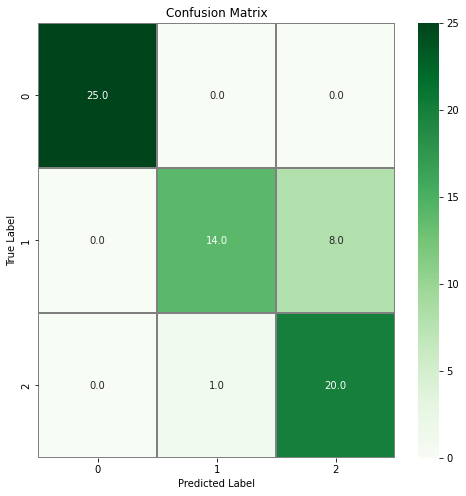

In [44]:
# confusion matrix
import seaborn as sns
 

# compute the confusion matrix
test_generator.reset()
confusion_mtx = confusion_matrix(test_generator.classes, test_pred_classes) 

# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

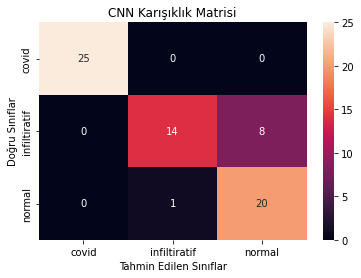

In [45]:
CATEGORIES = labels.values()

ax= plt.subplot()
sns.heatmap(confusion_mtx, annot=True, fmt="d", ) 
plt.xlabel("Tahmin Edilen Sınıflar")
plt.ylabel("Doğru Sınıflar")
plt.title("CNN Karışıklık Matrisi")
ax.xaxis.set_ticklabels(CATEGORIES); ax.yaxis.set_ticklabels(CATEGORIES);
plt.show()

In [46]:
#Confution Matrix and Classification Report
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, test_pred_classes))
print('Classification Report')
print(classification_report(test_generator.classes, test_pred_classes, target_names=CATEGORIES))

Confusion Matrix
[[25  0  0]
 [ 0 14  8]
 [ 0  1 20]]
Classification Report
              precision    recall  f1-score   support

       covid       1.00      1.00      1.00        25
infiltiratif       0.93      0.64      0.76        22
      normal       0.71      0.95      0.82        21

    accuracy                           0.87        68
   macro avg       0.88      0.86      0.86        68
weighted avg       0.89      0.87      0.86        68

